## Tutorial 3: Choosing hyperparameters for  augmented Lagrangian optimization.

Here, we will run the same EPI optimization as in Tutorials 1 and 2, but with different choices of augmented Lagrangian (AL) optimization hyperparameters. The stochastic constrained objective of EPI is optimized using an AL methodology elaborated below.  The hyperparameters of this optimization have default values, but it is useful to learn how to modify these choices for your application.  This tutorial should give an idea of what hyperparameters are suitable for a given EPI distribution, and how to design a hyperparameter search.

Throughout the tutorial, please refer to the API documentation at [https://epi.readthedocs.io/en/latest/API.html](https://epi.readthedocs.io/en/latest/API.html).

First, we'll run the setup code from Tutorials 1 and 2 right up until we invoke the EPI method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Mac OS jupyter kernel dies without.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from epi.models import Model, Parameter
import time

# 1. Define the model.
lb, ub = -10., 10.
a11 = Parameter("a11", 1, lb=lb, ub=ub)
a12 = Parameter("a12", 1, lb=lb, ub=ub)
a21 = Parameter("a21", 1, lb=lb, ub=ub)
a22 = Parameter("a22", 1, lb=lb, ub=ub)
name = "lds_2D"
params = [a11, a12, a21, a22]
M = Model(name, params)

# 2. Define the emergent property.
def linear2D_eig(a11, a12, a21, a22):
    tau = 1.0
    c11 = a11 / tau
    c12 = a12 / tau
    c21 = a21 / tau
    c22 = a22 / tau

    
    # Quadratic formula.
    real_term = 0.5 * (c11 + c22)
    complex_term = 0.5 * tf.sqrt(
        tf.complex(tf.square(c11 + c22) - 4.0 * (c11 * c22 - c12 * c21), 0.0)
    )
    real_lambda = real_term + tf.math.real(complex_term)
    imag_lambda = tf.math.imag(complex_term)

    T_x = tf.concat(
        (
            real_lambda,
            imag_lambda,
            tf.square(real_lambda - 0.),
            tf.square(imag_lambda - (2. * np.pi)),
        ),
        axis=1,
    )
    return T_x
M.set_eps(linear2D_eig)
mu = np.array([0.0, 2 * np.pi, 0.5**2, (0.2 * np.pi)**2])

### EPI optimization

The objective of EPI is

$$\underset{q_\theta \in Q}{\mathrm{arg max}} \hspace{.2cm} H(q_\theta(z))$$

$$\text{s.t.} \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] = \mu.$$

$q_\theta$ is optimized with the following augmented Lagrangian loss function:

$$L(\theta; \eta, c) = -H(q_\theta) + \eta^\top R(\theta) + \frac{c}{2}||R(\theta)||^2$$

where $R(\theta) = \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] - \mu$ is the vector of constraint violation.  This objective is optimized for $\eta_k$ and $c_k$, which are updated for each of the `K` augmented Lagrangian optimization epochs, which proceed for `num_iters` iterations until convergence.  Convergence (stochastic constraint adherance) is evaluated using a series of hypothesis tests  for each constraint.  The details are elaborated below.

#### Update rule for $\eta_k$ and $c_k$
$\eta_1$ is initialized to the zero vector, and $c_1$ is initialized to `c0`.  Following each augmented Lagrangian epoch, they are updated according to a criteria parameterized by hyperparameter $\gamma$ (optional parameter `gamma` of `Model.epi`) and by an amount parameterized by hyperparameter $\beta$ (optional parameter `beta` of `Model.epi`).

**Criteria**:

The p-value ($p$) of $\mathbb{E}[|R(\theta_{k})|] > \gamma \mathbb{E}[|R(\theta_{k-1})|]$ is computed.

**Update**:

Always, $\eta_{k+1} = \eta_k + c_k$.

With probability $1-p$, $c_{k+1} = \beta c_k$.

#### `c0` is very important!

The initialization of $c_1$ to `c0` is the most critical hyperparamter choice of the augmented Lagrangian.  It defines the initial tradeoff between constraint satisfaction and entropic growth of EPI, and will only increasingly weight constraint satisfaction during later epochs.

A general rule of thumb for well-behaved EPI optimizations is that an initial period of stable entropic growth should cover the modes of the distribution you wish to uncover.  This initial period of stable entropic growth should then be followed by iterative changes at each epoch until the constraints are satisfied.

Let's take a look at the 2D LDS oscillation EPI optimization at various choices of `c0`.

In [2]:
c0s = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
q_thetas = []
opt_datas = []

for i in range(len(c0s)):
    c0 = c0s[i]
    # Run EPI with coupling flow.
    print('Running EPI with c0 = %.2E.' % c0)
    q_theta, opt_data, _, _ = M.epi(
        mu,
        K = 20,
        num_iters = 2000,
        stop_early = True,
        c0=c0,
    )
    q_thetas.append(q_theta)
    opt_datas.append(opt_data)
    

Running EPI with c0 = 1.00E-05.
Initializing D4_C3_L2_U15_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/lds_2D_linear2D_eig//D4_C3_L2_U15_rs1/.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
EPI(k= 0,i=   0): cost  1.38E+03, H  5.71E+00, |R|^2 1.39E+03
EPI(k= 1,i=2000): cost -1.20E+01, H  1.20E+01, |R|^2 2.62E+03
EPI(k= 2,i=2000): cost -1.19E+01, H  1.20E+01, |R|^2 2.23E+03
EPI(k= 3,i=2000): cost -1.17E+01, H  1.19E+01, |R|^2 1.65E+03
EPI(k= 4,i=2000): cost -1.12E+01, H  1.18E+01, |R|^2 8.92E+02
EPI(k= 5,i=2000): cost -1.03E+01, H  1.12E+01, |R|^2 3.32E+02
EPI(k= 6,i=2000): cost -9.55E+00, H  1.03E+01, |R|^2 4.37E+01
EPI(k= 7,i=2000): cost -9.20E+00, H  9.95E+00, |R|^2 2.07E+01
EPI(k= 8,i=2000): cost -8.89E+00, H  9.52E+00, |R|^2 6.92E+00
EPI(k

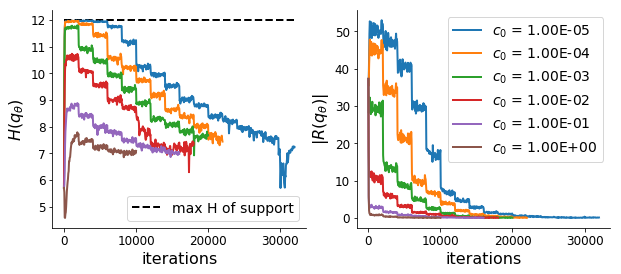

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

labels = [r"$c_0$ = %.2E" % c0 for c0 in c0s]
max_iter = 0.
for i in range(len(c0s)):
    Rs = opt_datas[i][['R%d' % j for j in range(1, M.m+1)]].to_numpy()
    R_norm = np.linalg.norm(Rs, axis=1)
    axs[1].plot(opt_datas[i]['iteration'], R_norm)
    _max_iter = opt_datas[i]['iteration'].max()
    if (_max_iter > max_iter):
        max_iter = _max_iter

H_max = -np.log(1/(20.**4))
axs[0].plot([0, max_iter], [H_max, H_max], 'k--')
for i in range(len(c0s)):
    axs[0].plot(opt_datas[i]['iteration'], opt_datas[i]['H'])
axs[0].legend(['max H of support'])
axs[0].set_xlabel('iterations')
axs[0].set_ylabel(r'$H(q_\theta)$')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel(r'$|R(q_\theta)|$')
axs[1].legend(labels)
plt.show()

The effect of `c0` on the EPI optimization is quite evident from the plots above.  Each EPI optimization was run for enough augmented Lagrangian epochs until convergence, with 2,000 iterations per epoch.  
    
We see that low values of `c0` (e.g. `1e-5`) result in fast entropic growth to the uniform distribution at the outset of optimization.  This can be desireable based on the application, however one should expect a greater number of epochs until convergence compared to a greater value of `c0=1`.

However, an important drawback of selecting a high `c0` is that you may miss interesting structure in the learned distribution.  For example, the lower entropy at convergence for `c0=1e-1` suggests that it did not uncover both modes.  This is probed out when plotting the distributions.

### `c0 = 1e-5` (catches both modes, but is slower)

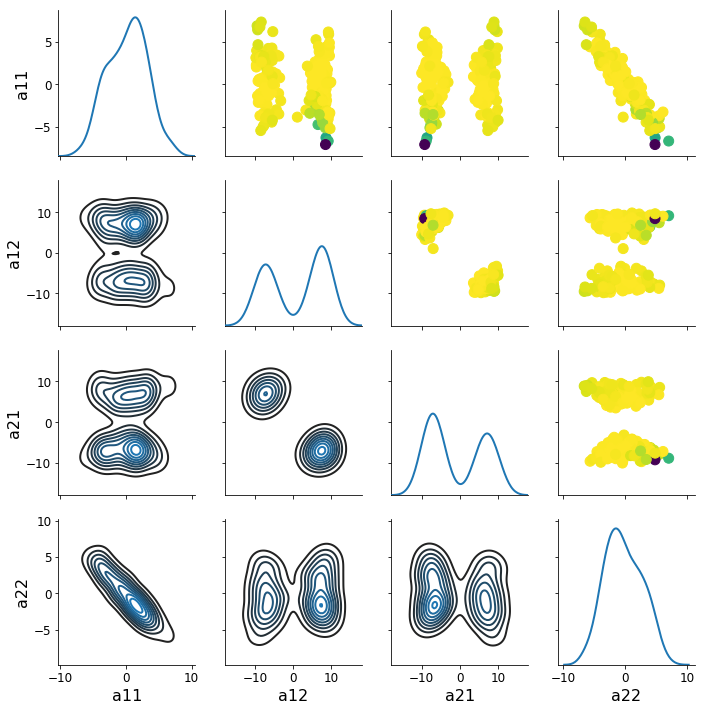

In [5]:
q_thetas[0].plot_dist()

### `c0 = 1` (misses other mode, but converges faster)

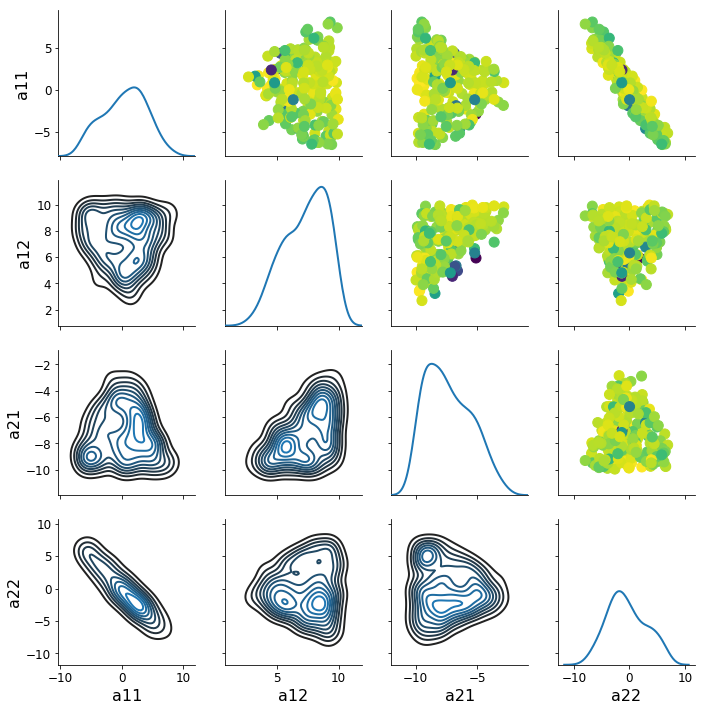

In [6]:
q_thetas[-1].plot_dist()

Ideally, we want to find a best `c0` for our EPI distribution (this will vary depending on the model, emergent property, and normalizing flow architecture), which yields max-ent convergence as quickly as possible. For this application, we could choose something like `c0=1e-2`.

### Best:  `c0 = 1e-2` (catches both modes, intermediate speed)


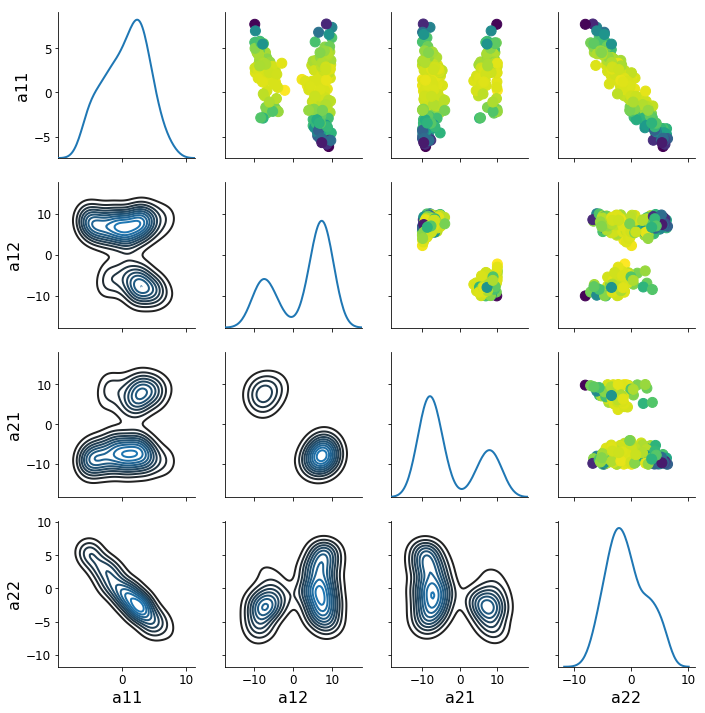

In [9]:
q_thetas[3].plot_dist()